In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap, cross_val_score_scratch

In [91]:
# Import other libraries
import pandas as pd
import numpy as np
import numbers
import matplotlib.pyplot as plt
import matplotlib as mpl
from imodels import HSTreeClassifier, HSTreeRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
import shap

# Strobl Simulation 

We replicate the simulation design used by where a binary response variable Y is predicted from a set of 5 predictor variables that vary in their scale of measurement and number of categories. The first predictor variable X1 is continuous, while the other predictor variables  X2,…,X5  are multinomial with  2,4,10,20  categories, respectively. The sample size for all simulation studies was set to n = 120. In the first all predictor variables and the response are sampled independently. We would hope that a reasonable variable importance measure would not prefer any one predictor variable over any other. In the second simulation study, the so-called , the distribution of the response is a binomial process with probabilities that depend on the value of  x2 , namely  P(y=1|X2=1)=0.35,P(y=1|X2=2)=0.65  .

In [159]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* 0.15))

    return X, y

In [167]:
def simulate_data_simple(n=120, M=100, imp_score="MDI", reg_param=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    featimp_sk_null = []
    featimp_im_null = []
    featimp_scr_null = []
    featimp_scrHS_null = []
    featimp_sk_power = []
    featimp_im_power = []
    featimp_scr_power = []
    featimp_scrHS_power = []
    
    #Null simulation
    X_null, y_null = simulate_data_strobl(n=n, M=M, relevance=0, seed=random_state)   
    #Power simulation
    X_power, y_power = simulate_data_strobl(n=n, M=M, relevance=0.15, seed=random_state)
    
    for i in range(M):
        
        #Fit sklearn
        clf_null_sk = DecisionTreeClassifier(random_state=42).fit(X_null[i,:,:], y_null[:,i])
        featimp_sk_null.append(clf_null_sk.feature_importances_)

        #Fit imodels
        clf_null_im = HSTreeClassifier(deepcopy(clf_null_sk), reg_param=reg_param)
        featimp_im_null.append(clf_null_im.estimator_.feature_importances_)

        #Fit scratch
        clf_null_scr = DecisionTree(treetype="classification", random_state=42)
        clf_null_scr.fit(X_null[i,:,:], y_null[:,i])
        featimp_scr_null.append(clf_null_scr.feature_importances_)
        
        #Fit scratch HS
        clf_null_scrHS = DecisionTree(treetype="classification", HShrinkage=True, HS_lambda=reg_param, random_state=42)
        clf_null_scrHS.fit(X_null[i,:,:], y_null[:,i])
        featimp_scrHS_null.append(clf_null_scrHS.feature_importances_)
        
        
        #Fit sklearn
        clf_power_sk = DecisionTreeClassifier(random_state=42).fit(X_power[i,:,:], y_power[:,i])
        featimp_sk_power.append(clf_power_sk.feature_importances_)

        #Fit imodels
        clf_power_im = HSTreeClassifier(deepcopy(clf_power_sk), reg_param=10)
        featimp_im_power.append(clf_power_im.estimator_.feature_importances_)

        #Fit scratch
        clf_power_scr = DecisionTree(treetype="classification", random_state=42)
        clf_power_scr.fit(X_power[i,:,:], y_power[:,i])
        featimp_scr_power.append(clf_power_scr.feature_importances_)
        
        #Fit scratch HS
        clf_power_scrHS = DecisionTree(treetype="classification", HShrinkage=True, HS_lambda=reg_param, random_state=42)
        clf_power_scrHS.fit(X_power[i,:,:], y_power[:,i])
        featimp_scrHS_power.append(clf_power_scrHS.feature_importances_)
        
    
    feat_imps_null = [featimp_sk_null, featimp_im_null, featimp_scr_null, featimp_scrHS_null]
    feat_imps_power = [featimp_sk_power, featimp_im_power, featimp_scr_power, featimp_scrHS_power]
    
    return [X_null, y_null], [X_power, y_power], feat_imps_null, feat_imps_power


In [168]:
[X_null, y_null], [X_power, y_power], feat_imps_null, feat_imps_power = simulate_data_simple(random_seed=42)

In [174]:
np.array(feat_imps_null[0]).mean(axis=0)

array([0.38798636, 0.09478272, 0.10626073, 0.17400714, 0.23696305])

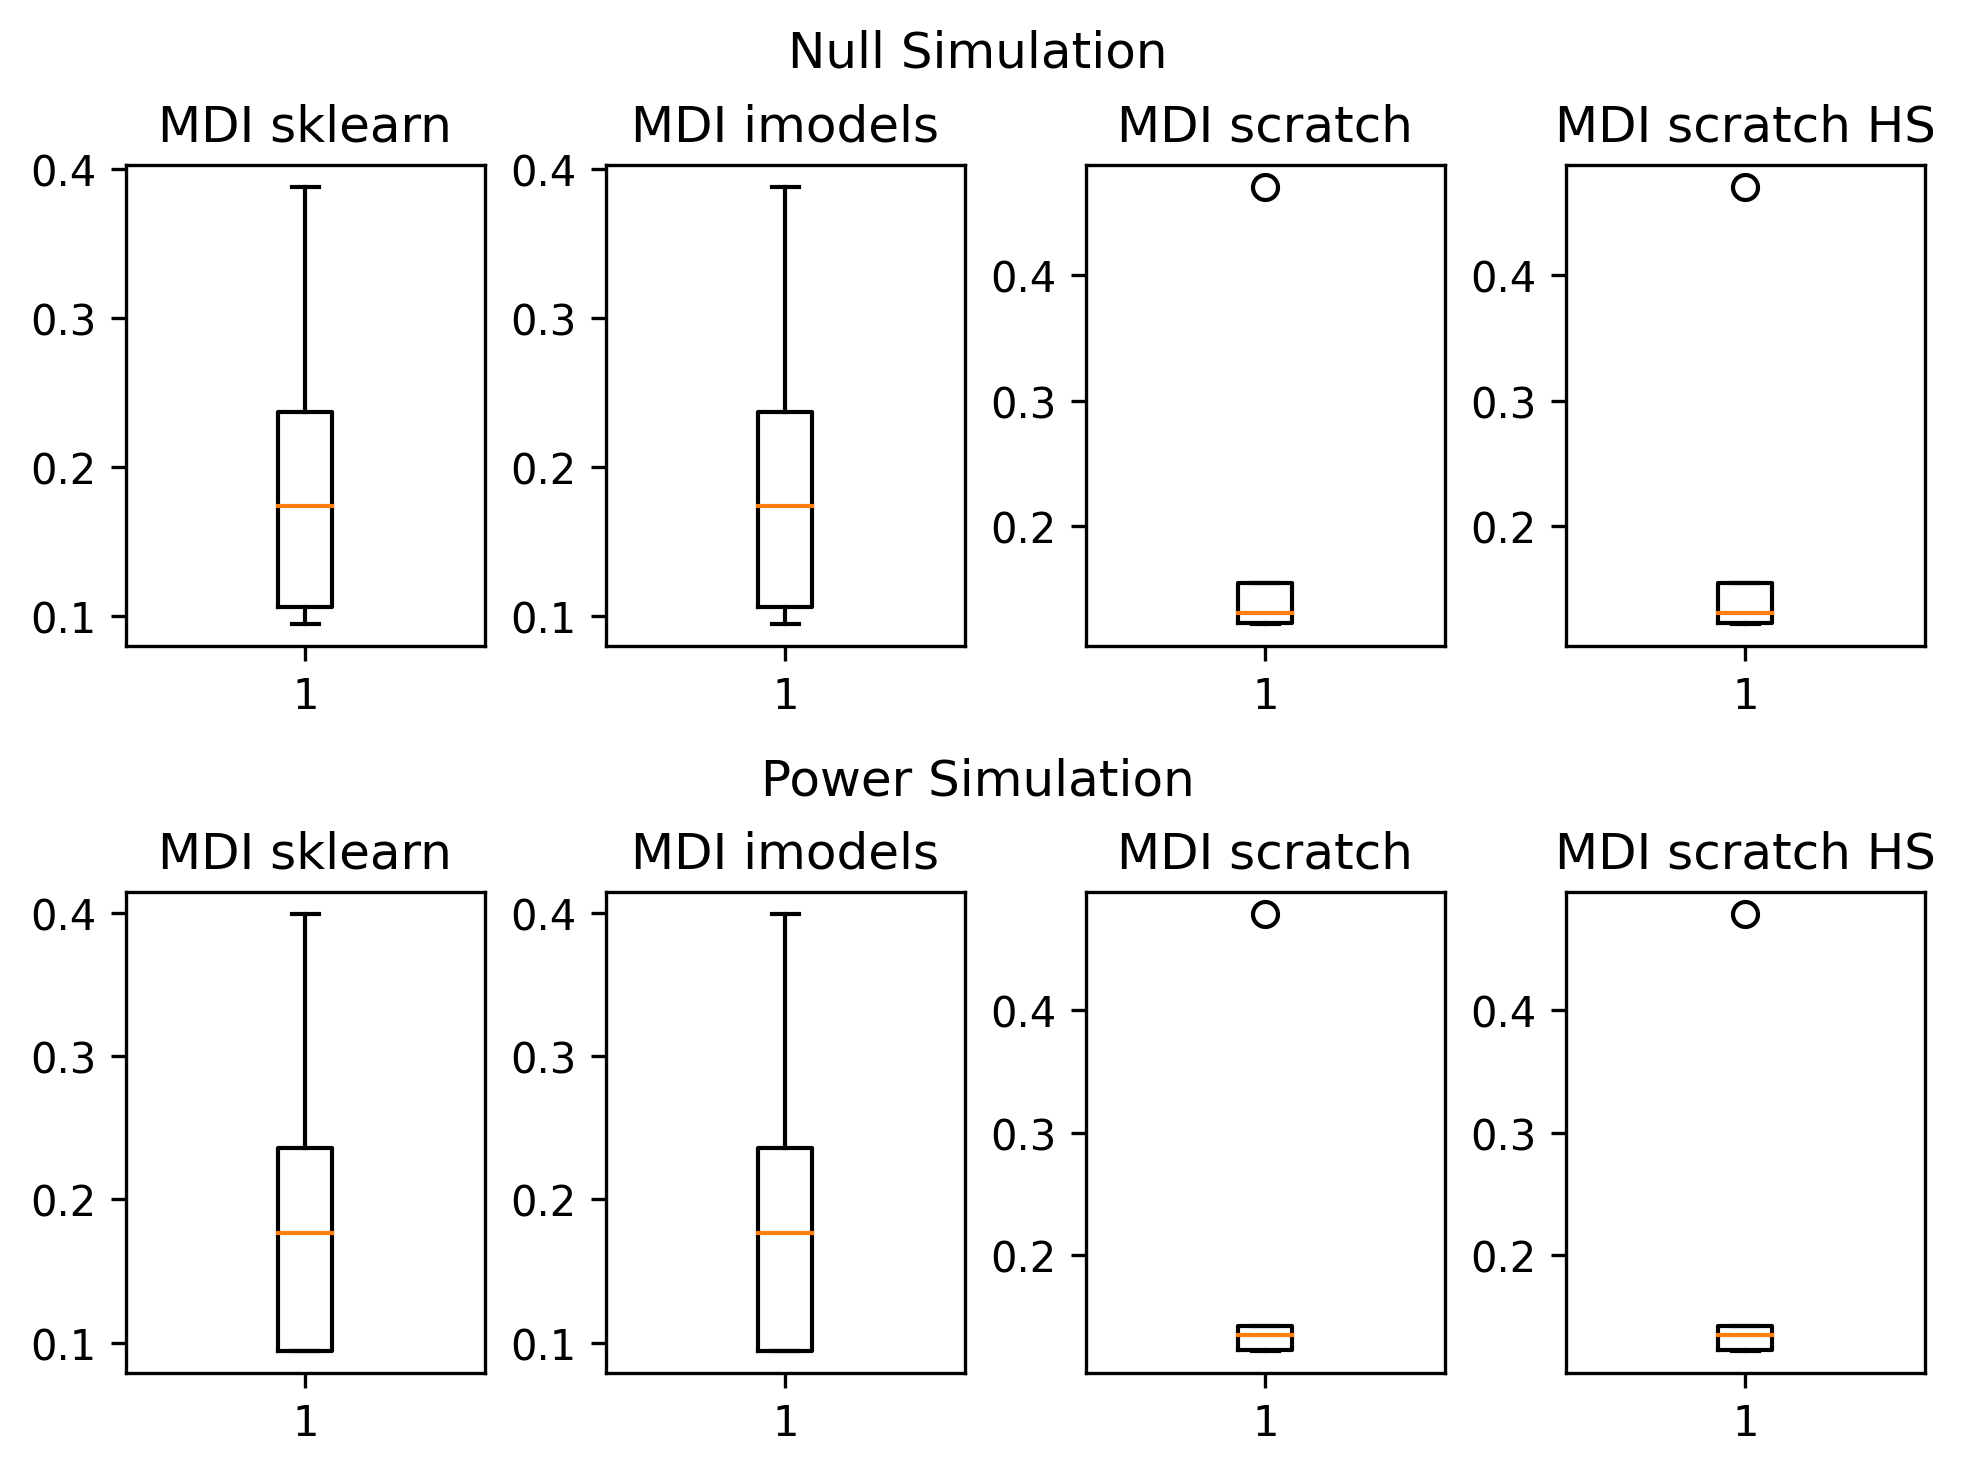

In [178]:
fig = plt.figure(constrained_layout=True)

(subfig1, subfig2) = fig.subfigures(2, 1)      # create 2x1 subfigures
axs1 = subfig1.subplots(1, 4)       # create 1x2 subplots on subfig1
axs2 = subfig2.subplots(1, 4)       # create 1x2 subplots on subfig2

subfig1.suptitle('Null Simulation')            # set suptitle for subfig1
axs1[0].boxplot(np.array(feat_imps_null[0]).mean(axis=0))
axs1[0].set_title('MDI sklearn')
axs1[1].boxplot(np.array(feat_imps_null[1]).mean(axis=0))
axs1[1].set_title('MDI imodels')
axs1[2].boxplot(np.array(feat_imps_null[2]).mean(axis=0))
axs1[2].set_title('MDI scratch')
axs1[3].boxplot(np.array(feat_imps_null[3]).mean(axis=0))
axs1[3].set_title('MDI scratch HS')

subfig2.suptitle('Power Simulation')    # set suptitle for subfig2
axs2[0].boxplot(np.array(feat_imps_power[0]).mean(axis=0))
axs2[0].set_title('MDI sklearn')
axs2[1].boxplot(np.array(feat_imps_power[1]).mean(axis=0))
axs2[1].set_title('MDI imodels')
axs2[2].boxplot(np.array(feat_imps_power[2]).mean(axis=0))
axs2[2].set_title('MDI scratch')
axs2[3].boxplot(np.array(feat_imps_power[3]).mean(axis=0))
axs2[3].set_title('MDI scratch HS');
